In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D


print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.4.1


In [2]:
base_dir = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [3]:
WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [4]:
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


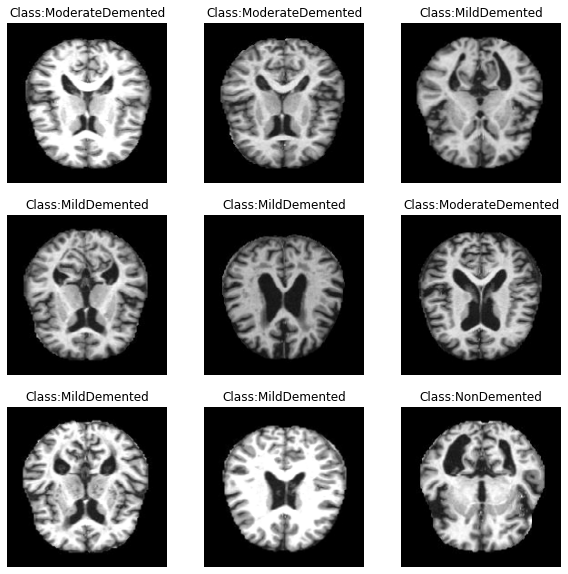

In [5]:
def show_images(generator,y_pred=None):
    
    labels =dict(zip([0,1,2,3], CLASSES))
    
    x,y = generator.next()
    
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

In [6]:
train_data, train_labels = train_data_gen.next()

In [7]:
print(train_data.shape, train_labels.shape)

(6400, 176, 176, 3) (6400, 4)


In [8]:
sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [9]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [10]:
inception_model = InceptionV3(input_shape=(176, 176, 3), include_top=False, weights="imagenet")

87916544/87910968 [==============================] - 1s 0us/step


In [11]:
custom_inception_model = Sequential([
        inception_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')        
    ], name = "inception_cnn_model")

In [12]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)

In [13]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           tfa.metrics.F1Score(num_classes=4)]

CALLBACKS = [my_callback, rop_callback]
    
custom_inception_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

custom_inception_model.summary()

Model: "inception_cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 4, 4, 2048)        21802784  
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 2048)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
batch_normalization_94 (Batc (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
batch_normalization_95 (Batc (None, 512)       

In [14]:
EPOCHS = 50

history = custom_inception_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/50
256/256 [==============================] - 52s 137ms/step - loss: 1.7757 - acc: 0.2569 - auc: 0.5017 - f1_score: 0.2566 - val_loss: 315.8569 - val_acc: 0.2661 - val_auc: 0.5352 - val_f1_score: 0.1747
Epoch 2/50
256/256 [==============================] - 33s 128ms/step - loss: 1.5017 - acc: 0.2600 - auc: 0.5147 - f1_score: 0.2596 - val_loss: 1.4912 - val_acc: 0.2217 - val_auc: 0.4765 - val_f1_score: 0.1659
Epoch 3/50
256/256 [==============================] - 33s 129ms/step - loss: 1.4232 - acc: 0.2611 - auc: 0.5133 - f1_score: 0.2599 - val_loss: 1.3901 - val_acc: 0.2563 - val_auc: 0.5015 - val_f1_score: 0.1494
Epoch 4/50
256/256 [==============================] - 33s 129ms/step - loss: 1.4028 - acc: 0.2548 - auc: 0.5093 - f1_score: 0.2528 - val_loss: 1218.1554 - val_acc: 0.2612 - val_auc: 0.5072 - val_f1_score: 0.1045
Epoch 5/50
256/256 [==============================] - 33s 129ms/step - loss: 1.3962 - acc: 0.2503 - auc: 0.5014 - f1_score: 0.2469 - val_loss: 1.3683 - val_acc

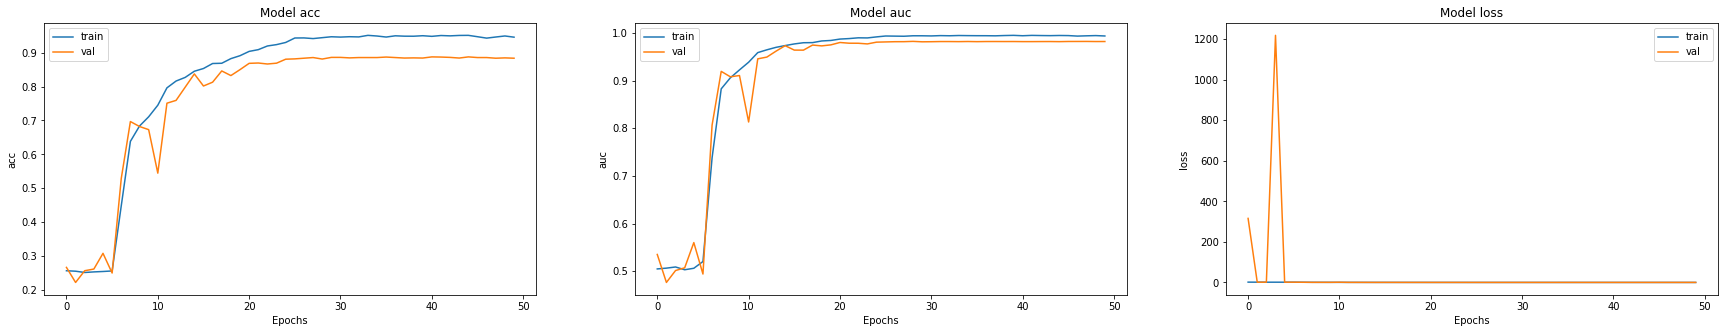

In [15]:
fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [16]:
#train_scores = custom_inception_model.evaluate(train_data, train_labels)
#val_scores = custom_inception_model.evaluate(val_data, val_labels)
test_scores = custom_inception_model.evaluate(test_data, test_labels)

#print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
#print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

80/80 [==============================] - 3s 38ms/step - loss: 0.3433 - acc: 0.8691 - auc: 0.9805 - f1_score: 0.8695
Testing Accuracy: 86.91%


In [17]:
pred_labels = custom_inception_model.predict(test_data)

In [18]:
def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.92      0.95      0.93       639
VeryMildDemented       1.00      1.00      1.00       635
    MildDemented       0.87      0.71      0.78       662
ModerateDemented       0.70      0.83      0.76       624

       micro avg       0.87      0.87      0.87      2560
       macro avg       0.88      0.87      0.87      2560
    weighted avg       0.88      0.87      0.87      2560
     samples avg       0.87      0.87      0.87      2560



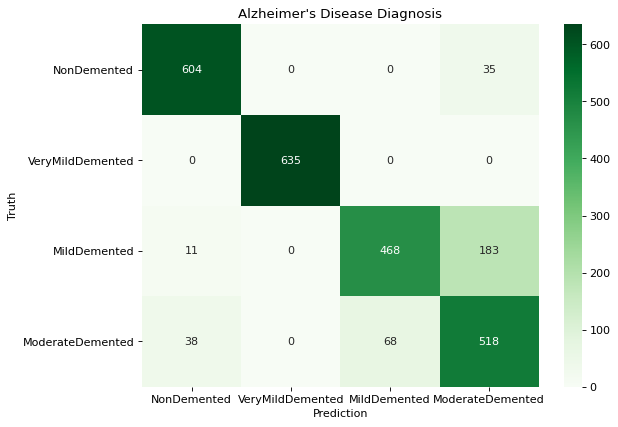

In [19]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= CLASSES,
                yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [20]:
#custom_inception_model.save('./dataset/alzheimer_model.h5')

In [21]:
#prebuild_model = tf.keras.models.load_model('alzheimer_model.h5')

In [22]:
#import numpy as np
#import tensorflow as tf
#from skimage import transform
#from PIL import Image

In [23]:
"""def pre_process(image):
  np_image = np.array(image).astype('float32')/255
  np_image = transform.resize(np_image, (176, 176, 3))
  np_image = np.expand_dims(np_image, axis=0)
  return np_image

def makecalc():
  image = Image.open('/content/mildDem0.jpg')
  tensor = pre_process(image)
  loaded_model = tf.keras.models.load_model('/content/alzheimer_inception_cnn_model',)
  opt = loaded_model.predict(tensor)
  return (np.argmax(opt))"""

"def pre_process(image):\n  np_image = np.array(image).astype('float32')/255\n  np_image = transform.resize(np_image, (176, 176, 3))\n  np_image = np.expand_dims(np_image, axis=0)\n  return np_image\n\ndef makecalc():\n  image = Image.open('/content/mildDem0.jpg')\n  tensor = pre_process(image)\n  loaded_model = tf.keras.models.load_model('/content/alzheimer_inception_cnn_model',)\n  opt = loaded_model.predict(tensor)\n  return (np.argmax(opt))"